# Aircraft Configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [2]:
import numpy as np
import pydot
from airconics.topology import Topology_GPTools, Topology

from IPython.display import Image, display

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

<TornadoWebRenderer at http://PChambers_ngcm:45796/get/796d9f1f19c349fbae74c9c8de728b16>

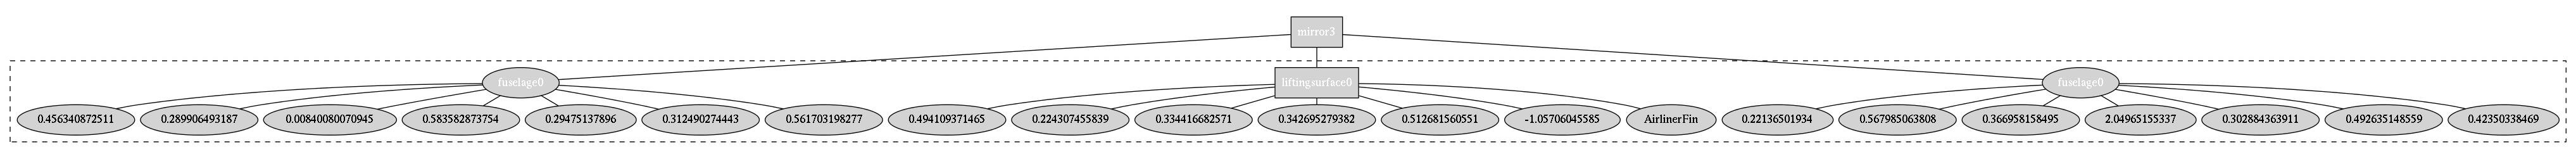

In [3]:
topo_tools = Topology_GPTools(MaxAttachments=4)
# Try to compile a single individual and visualise both the tree and geometry
topo = topo_tools.randomize()

renderer = TornadoWebRenderer()
topo.Display(renderer)

display(renderer)
display(Image(topo.pydot_graph().create_png()))

## Conventional Airliner

In [ ]:
import os, airconics
from airconics import Topology
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer
from IPython.display import Image, display

topo = Topology()

fname = os.path.join(os.path.dirname(airconics.__file__),'resources/configuration_app/presets/airliner.json')

topo.from_file(fname)

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))

renderer

## General Atomics MQ-1 Predator

### Aircraft configuration from JSON files

User defined JSON can be used to create new component hierarchies using the `Topology_GPTools.from_file` or `from_JSON` methods. This offers an interface for describing new aircraft layouts that is human-readable. The format is described in the table below; see the [presets directory](https://github.com/p-chambers/occ_airconics/tree/v0.3-dev/airconics/resources/configuration_app/presets) on github for examples.

<b>Notes:
* Attributes are not order sensitive, but each of the named attributes must appear once
* The `<N>` should be replaced with a number describing the number of descendent
* The order that component fitting primitives appear in the JSON file DOES affect the result
    - If a component with two sub attachments (`liftingsurface2`) appears in the file, the following two components will be sub geometries of that lifting surface. 
* Scalar variable inputs are all expected to lie between 0 and 1, unless otherwise specified; this dimensionless value is then used to fit the geometry to its parent.
* The lifting surface `Type` attribute can be any of keys the pre-defined wing types `airconics.topology.LSURF_FUNCTIONS` dictionary, e.g., `"AirlinerWing"`, `"TaperedWing"`, etc.
</b>.

<table>
	<col width="3">
	<col width="6">
	<tr>
		<th>Primitive Name</th>
		<th>Attributes</th>
	</tr>
	<tr>
		<td>liftingsurfaceN</td>
		<td>$X$ : longitudinal position, scalar<br>
$Y$ : lateral position, scalar<br>
$Z$ : vertical position, scalar<br>
ChordFactor : scalar<br>
ScaleFactor : scalar<br>
Rotation : scalar (−1 < Rotation < 1)<br>
Type : wing type, string (see **notes** above)</td>
	</tr>
	<tr>
		<td>fuselageN</td>
		<td>$X$ : longitudinal position, scalar<br>
$Y$ : lateral position, scalar<br>
$Z$ : vertical position, scalar<br>
XScaleFactor : scalar<br>
NoseLengthRatio : scalar<br>
TailLengthRatio : scalar<br>
FinenessRatio : scalar	</td>
	</tr>
	<tr>
		<td>mirrorN</td>
		<td>None. This primitive simply mirrors N direct descendants, and their associated subtrees, in the $XZ$ plane.</td>
	</tr>
</table>


We'll use the [predator example](https://github.com/p-chambers/occ_airconics/blob/v0.3-dev/airconics/resources/configuration_app/presets/predator.json) here for demonstration.

In [ ]:
import os, airconics
from airconics import Topology, topology
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer
from IPython.display import Image, display
from deap import gp

topology.NODE_PROPERTIES = {'fuselage': {'shape': 'ellipse'},
                   'liftingsurface': {'shape': 'box'},
                   'engine': {'shape': 'hexagon'},
                   'mirror': {'shape': 'box'},
                   'number': {'shape': 'ellipse', 'fillcolor': '#00000000'},
                   'function': {'shape': 'ellipse', 'fillcolor': '#00000000'},
                   'None': {'shape': 'point'},
                   }

topo = Topology(SimplificationReqd=True)

fname = os.path.join(os.path.dirname(airconics.__file__),'resources/configuration_app/presets/proteus.json')

topo.from_file(fname)

renderer = TornadoWebRenderer()

topo.Display(renderer)

nodes, edges, labels = gp.graph(topo._deap_tree)

mirror_flag = False

graph = pydot.Dot(ranksep='0.1', nodesep='0.1')
graph.set_node_defaults(style='filled')
graph.set_edge_defaults(arrowhead='none')

cluster_1 = pydot.Cluster('standard', color='invis')
graph.add_subgraph(cluster_1)

N_mirrored = 0

# Add a sub cluster for mirrored objects (does nothing if empty)
cluster_2 = pydot.Cluster('mirrored', style='dashed')

# i is used to increment the number of Geometric parts that have been
# found in the main loop (required as component names are prepended
# with their ordinal component number, and component names need to be
# matched with the _deap_tree)
i = 0
# use a boolean flag to decide if subclusters should be added to
# the cluster of mirrored components (clutser_2)
mirror_flag = False

for node in nodes:
    # note: this only works because the node number is manually added
    # to the label by boxn:

    label = labels[node]

    try:
        # if label is a string, get the name of the function (remove
        # arity value at the end of the string)
        nodetype = label.rstrip('0123456789')

        if nodetype in topology.NODE_PROPERTIES:

            arity = label.lstrip(nodetype)
            N_mirrored += int(arity) + \
                len(Topology.ComponentTypes[nodetype][1])
        else:
            # if the nodetype is a string, but not a known nodetype,
            # then assume it's a lifting surface parametric function:
            nodetype = 'function'


    except AttributeError:
        if isinstance(label, float):
            # Assume the value is a float
            label = "{}".format(label)
        nodetype = 'number'

    pydot_node = pydot.Node(
        node, label=label, **topology.NODE_PROPERTIES[nodetype])

    if mirror_flag:
        cluster_2.add_node(pydot_node)
        N_mirrored -= 1
    else:
        cluster_1.add_node(pydot_node)

    if nodetype == "mirror":
        mirror_flag = True
    elif N_mirrored == 0:
        mirror_flag = False

graph.add_subgraph(cluster_2)

for edge in edges:
    src, dest = edge
    pydot_edge = pydot.Edge(src, dest)
    graph.add_edge(pydot_edge)

display(Image(topo.pydot_graph().create_png()))

# print(graph.create_dot())
# graph.write_svg('../thunderbolt_tree.svg')

# topo.Write('Thunderbolt.stp')
    
renderer

Why not also try creating one from scratch? Let's aim for the Scaled Composites Proteus:

![SC Proteus aircraft](Proteus.jpg)
**Photo source: NASA**

In [ ]:
import os, airconics
from airconics import Topology, topology
import numpy as np
import pydot
from airconics.topology import Topology_GPTools
from IPython.display import Image, display
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

# For publications, this colour/style is better
topology.NODE_PROPERTIES = {'fuselage': {'shape': 'ellipse'},
                   'liftingsurface': {'shape': 'box'},
                   'engine': {'shape': 'hexagon'},
                   'mirror': {'shape': 'box'},
                   'number': {'shape': 'ellipse', 'fillcolor': '#00000000'},
                   'function': {'shape': 'ellipse', 'fillcolor': '#00000000'},
                   'None': {'shape': 'point'},
                   }



# Note that we don't have to do anything special to turn a list of
# dictionaries into json format before calling topo_tools.from_json:
#  The primtives_array is already in json format!
primitives_array = [
  {
    "primitive": "fuselage1", 
    "args": {
        "X": 0.0, 
        "Y": 0.0, 
        "Z": 0.0,
        "XScaleFactor": 1.0,
        "NoseLengthRatio": 0.182,
        "TailLengthRatio": 0.293,
        "FinenessRatio": 1.0
      }
  },
  {
    "primitive": "mirror3"
  }, 
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.27, 
        "Y": 0.0, 
        "Z": 0.68,     
        "ScaleFactor": 0.42,
        "ChordFactor": 0.22,
        "Rotation": 0.05, 
        "Type": "StraightWing"
    }
  },
  {
    "primitive": "engine0",
    "args": {
        "SpanStation": 0.75,
        "XChordFactor": 0.16,
        "DiameterLenRatio": 0.21,
        "PylonSweep": -0.75,
        "PylonLenRatio": 0.5,
        "Rotation": 2.36
    }
},

  {
    "primitive": "liftingsurface1", 
    "args": {
        "X": 0.77,
        "Y": 0.0, 
        "Z": 0.3, 
        "ChordFactor": 0.8, 
        "ScaleFactor": 0.14,
        "Rotation": 0.09, 
        "Type": "StraightWing"
    }
  },
  {
    "primitive": "fuselage3", 
    "args": {
        "X": 1.0, 
        "Y": 1.0, 
        "Z": 1.0,
        "XScaleFactor": 2.8,
        "NoseLengthRatio": 0.18,
        "TailLengthRatio": 0.29,
        "FinenessRatio": 1.0
    }
  }, 
  {
    "primitive": "liftingsurface1",
    "args": {
        "X": 0.0, 
        "Y": 0.0, 
        "Z": 0.0,     
        "ScaleFactor": 0.9,
        "ChordFactor": 0.31,
        "Rotation": 0.09, 
        "Type": "StraightWing"
    }
  },
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 1.0,
        "Y": 1.0, 
        "Z": 1.0, 
        "ChordFactor": 0.42,
        "ScaleFactor": 0.7,
        "Rotation": -0.16, 
        "Type": "TaperedWing"
    }
  }, 
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.67,
        "Y": 0.0, 
        "Z": 0.1, 
        "ChordFactor": 1.0,
        "ScaleFactor": 0.4,
        "Rotation": -1.57, 
        "Type": "AirlinerFin"
    }
  }, 
  {
    "primitive": "liftingsurface0",
    "args": {
        "X": 0.67,
        "Y": 0.0, 
        "Z": 0.9, 
        "ChordFactor": 1.0, 
        "ScaleFactor": 0.42,
        "Rotation": 1.57, 
        "Type": "AirlinerFin"
    }
  }
]

topo = Topology(SimplificationReqd=False)
topo.from_json(primitives_array)
# topo.Write('Proteus.step')

renderer = TornadoWebRenderer()

topo.Display(renderer)

display(Image(topo.pydot_graph().create_png()))
graph = topo.pydot_graph()
graph.write_pdf

renderer

## Optimisation

**Note**: The optimisation setup code provided here is already included in the `Topology_GPTools` class, and can be used as default via the `Topology_GPTools.optimize` method. It is included here for those interested in how the evolutionary algorithm operates.

### The Objective Function

User-defined functions for the topology optimisation are catered for in the `Topology_GPTools` class. The function should take in a `Topology` (See: `airconics.topology.Topology`), and return a single number: default behaviour is that this measure of fitness will be maximised, i.e., topologies with a greater value returned by this function will be selected more favourably for mutation, reproduction, etc.

The objective function shown below will be used to maximise the similarity of an individuals component tree to a reference case: the airliner model. With this setup, the evolutionary algorithm will be subject to a simple test case for the genetic algorithm: that is, to test if the evolutionary process can obtain a given solution, without giving it any knowledge of what the solution is.

Considering that 'success' in this case would be achieved if the algorithm yields a geometry and configuration that is suitably (visually?) similar to the airliner model, results of interest should be,

* what population size, and number of generations gives a good probability of 'success'
* 

In [ ]:
from airconics.topology import Topology_GPTools, Topology, create_diffed_fitness
import os
import numpy as np
from IPython.display import Image, display
from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer
import airconics

# Use the proteus.json preset to 'diff' against
fname_reference = os.path.join(os.path.dirname(airconics.__file__),
                     'resources/configuration_app/presets/airliner.json')
diffed_fitness = create_diffed_fitness(fname_reference)

In [ ]:
# Check that the fitness function gives back a zero if the tree is exactly the same
topo = Topology()

topo.from_file(fname_reference)

tree_json = topo.to_json()
tree_components = [node['primitive'] for node in tree_json]



print(diffed_fitness(topo))
assert(diffed_fitness(topo) == 0)

### Evolution Setup

In [ ]:
from deap import tools, gp, algorithms
from airconics.topology import generate_topology
import random 

random.seed(69)

# The below are the default settings for Topology_GPTools, and are
# included for illustration. See docs or help for explanation of inputs
topo_tools = Topology_GPTools(MaxAttachments=4,
                              min_levels=2,
                              max_levels=4,
                              min_mut=1,
                              max_mut=4,
                              fitness_funct=diffed_fitness,
                             fitness_weights=(-1.0,),
                             history=True)  # Minimization!


# For now, I'll remove the construction of the geometry. This part
# takes time, and the current fitness function doesn't require a
# full CAD model - full scale analysis simulation would leave this in.
def eval_topology_treeonly(individual, pset, diff_funct):
    # simulate a topology run
    topo = airconics.Topology(construct_geometry=False)
    routine = gp.compile(individual, pset)
    topo.run(routine)
    return diff_funct(topo),

topo_tools._toolbox.register("evaluate", eval_topology_treeonly, pset=topo_tools._pset, diff_funct=diffed_fitness)


# This is small in GP, but this is used for demonstration purposes.
# Larger scale simulations should have a much larger population.
popsize = 2000

import time
t = time.time()
population, logbook, hof, gen_best = topo_tools.optimize(n=popsize, cxpd=0.5, mutpd=0.2, ngen=200)
print("Evolution took {} seconds".format(time.time() - t))

# get the best individual and rerun it:
best = hof[0]
best_topology = topo_tools.spawn_topology(best)

renderer = TornadoWebRenderer()

best_topology.Display(renderer)

renderer

In [ ]:
display(Image(best_topology.pydot_graph().create_png()))

In [ ]:
# Here's some code for creating the network diagram, but the
# diagram doesn't show a lot, and can take a long time to generate:
#  leaving this commented out for now.

# import networkx
# import matplotlib.pyplot as plt
# %matplotlib notebook

# graph = networkx.DiGraph(topo_tools.history.getGenealogy(best))
# graph = graph.reverse()     # Make the grah top-down

# colors = [topo_tools._toolbox.evaluate(topo_tools.history.genealogy_history[i])[0] for i in graph]
# networkx.draw(graph, node_color=colors, show='ipynb')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
# Write and plot the accompanying statistics of the evolution
gen, best, worst, avg = logbook.select("gen", "min", "max", "avg")
log_array = np.column_stack([gen, best, worst, avg])
# print(log_array)
np.savetxt('log.txt', log_array, header='gen    best(min)    worst    avg')

# Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(gen, best, 'b-', label=r'Best')
ax1.plot(gen, worst, 'r-', label=r'Worst')
ax1.plot(gen, avg, 'g-', label=r'Avg')

ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.legend(loc="upper right")